# Convolutional Neural Networks for Animal Image Classification

Objective: Compare baseline dense networks with CNN architectures and analyze the role of convolutional layers in image classification tasks using a multi-class animal dataset.

## Dataset Selection and Justification

We use the [Animal Computer Vision Clean Dataset & Code CNN-AI](https://www.kaggle.com/datasets/emirhanai/animal-computer-vision-clean-dataset-code-cnnai?resource=download) dataset from Kaggle, developed by *Emirhan Bulut*. This dataset contains high-quality images of four animal classes:

* Zebra
* Rhino
* Elephant
* Buffalo

The dataset consists of 4000 images (≈228 MB), making it significantly larger and more diverse than toy datasets, while still being manageable for experimentation with convolutional neural networks.

This dataset is well suited for the assignment because:

* It is image-based and specifically designed for computer vision tasks
* The classes present distinct visual characteristics (body shape, texture, size, patterns), ideal for convolutional feature extraction
* The dataset size allows meaningful training of CNNs while still exposing risks such as overfitting in simpler dense architectures
* It enables a clear and fair comparison between fully connected networks and CNN-based models

Additionally, the dataset has been previously validated in a CNN-based classification pipeline, achieving high performance metrics (≈97% accuracy), which makes it a reliable benchmark for analyzing architectural design choices rather than data quality issues.

The dataset encourages the use of intentional CNN architectures, emphasizing the importance of convolutional layers, spatial feature learning, and inductive bias in image classification problems.

## Setup and Imports

In [9]:
# Install required libraries (run this once if needed)
# %pip install numpy pandas matplotlib tensorflow scikit-learn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


## 1. Dataset Exploration (EDA)

In [10]:
# define datset path
DATASET_PATH = "./data/Animals"
CLASSES = ['Buffalo', 'Elephant', 'Rhino', 'Zebra']
NUM_CLASSES = len(CLASSES)
IMG_SIZE = (128, 128)
INPUT_SHAPE = (*IMG_SIZE, 3)

In [11]:
# Analyze dataset structure
def analyze_dataset_structure(dataset_path):
    class_counts = {}
    image_dimensions = []
    
    for class_name in CLASSES:
        class_path = os.path.join(DATASET_PATH, class_name)
        if os.path.exists(class_path):
            images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            class_counts[class_name] = len(images)
            
            # Sample a few images to check dimensions
            for img_file in images[:5]:
                img_path = os.path.join(class_path, img_file)
                try:
                    img = Image.open(img_path)
                    image_dimensions.append(img.size)
                except:
                    pass
    
    return class_counts, image_dimensions

class_counts, image_dims = analyze_dataset_structure(DATASET_PATH)

print("Dataset Summary:")
print(f"\nTotal classes: {NUM_CLASSES}")
print(f"Total images: {sum(class_counts.values())}")
print(f"\nClass Distribution:")
for class_name, count in class_counts.items():
    print(f"  {class_name:12s}: {count:3d} images ({count/sum(class_counts.values())*100:.1f}%)")

Dataset Summary:

Total classes: 4
Total images: 4000

Class Distribution:
  Buffalo     : 1000 images (25.0%)
  Elephant    : 1000 images (25.0%)
  Rhino       : 1000 images (25.0%)
  Zebra       : 1000 images (25.0%)


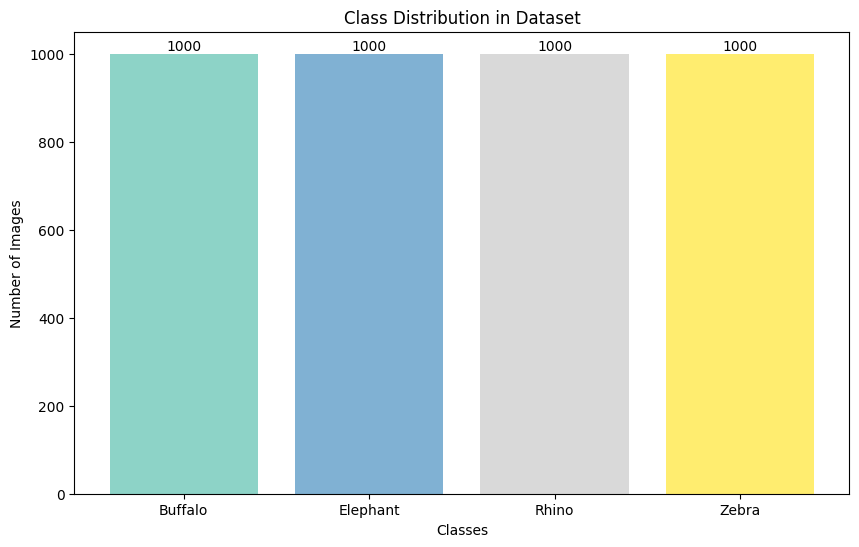

In [12]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(class_counts)))
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Dataset')
# Add value labels on bars
for i, count in enumerate(class_counts.values()):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')
plt.show()


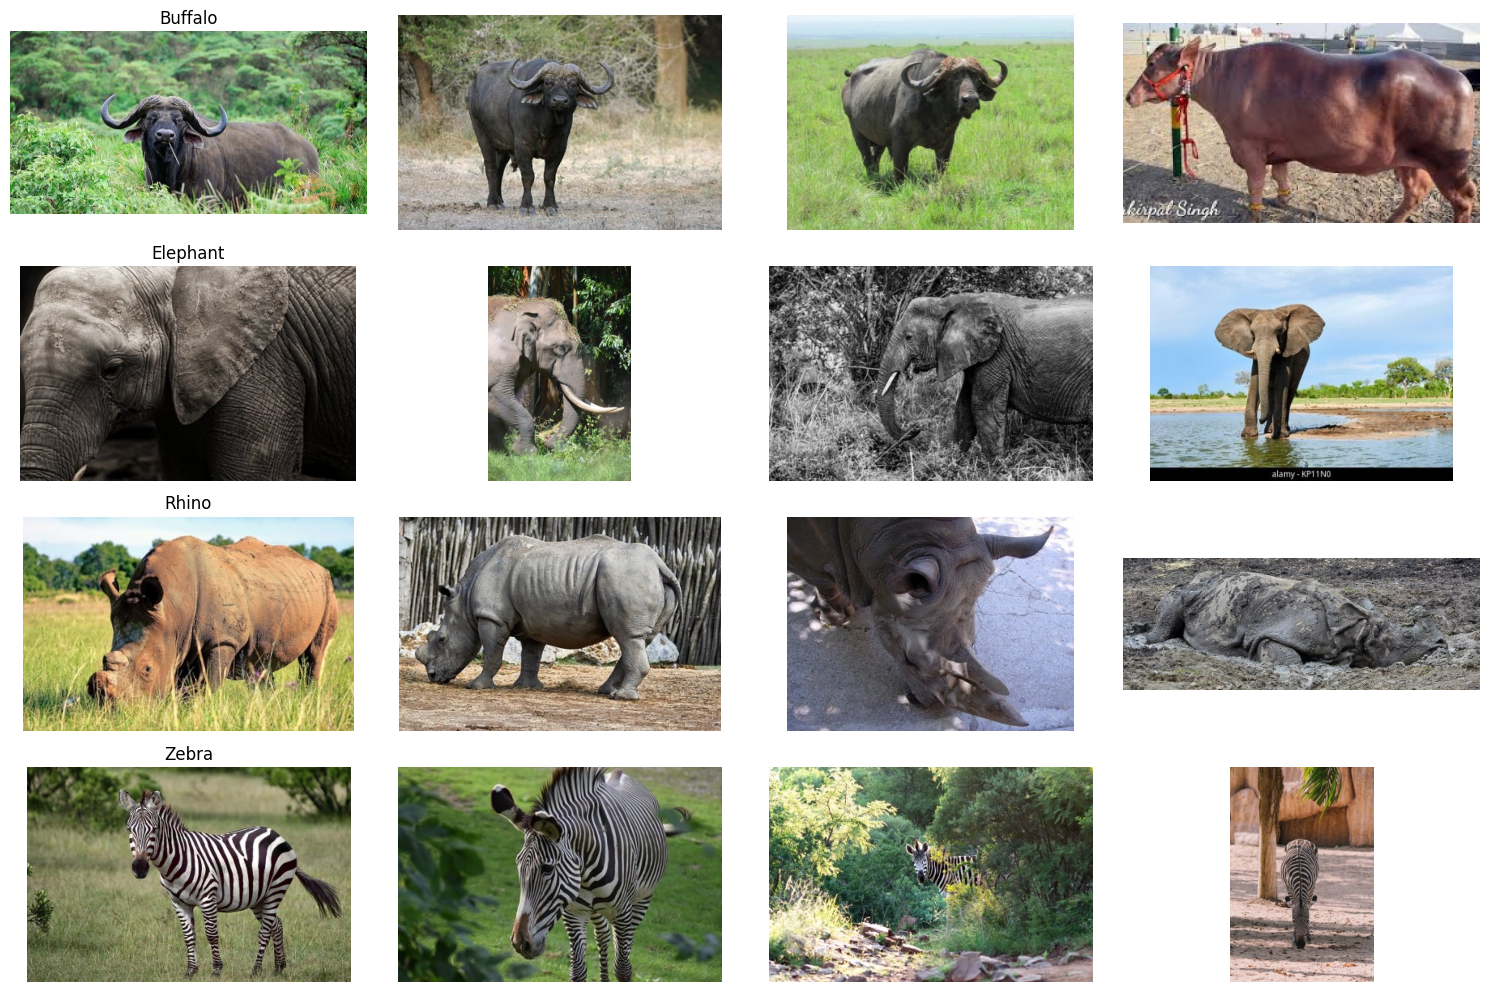

In [13]:
# Display sample images from each class
def display_sample_images(dataset_path, classes, num_samples=4):
    plt.figure(figsize=(15, 10))
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.exists(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            sample_images = images[:num_samples]
            
            for j, img_file in enumerate(sample_images):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = plt.imread(img_path)
                    plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
                    plt.imshow(img)
                    plt.axis('off')
                    if j == 0:
                        plt.title(class_name)
                except Exception as e:
                    print(f"Error loading {img_file}: {e}")
                    plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
                    plt.imshow(np.zeros((100, 100, 3)))
                    plt.axis('off')
                    if j == 0:
                        plt.title(f"{class_name} (error)")
    
    plt.tight_layout()
    plt.show()

display_sample_images(DATASET_PATH, CLASSES)

### Data Loading and Preprocessing
Load images and labels, resize, and normalize.
Preprocessing steps:
1. Resize all images to consistent dimensions
2. Convert to RGB (in case of grayscale)
3. Normalize pixel values to [0, 1]

In [14]:
def load_dataset(dataset_path, classes, img_size):
    images = []
    labels = []
    failed_count = 0
    
    for class_idx, cls in enumerate(classes):
        cls_path = os.path.join(dataset_path, cls)
        files = [f for f in os.listdir(cls_path) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        print(f"Loading {cls}: {len(files)} images...", end=' ')
        
        for fname in files:
            fpath = os.path.join(cls_path, fname)
            try:
                img = keras.preprocessing.image.load_img(
                    fpath, target_size=img_size, color_mode='rgb'
                )
                img_array = keras.preprocessing.image.img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(class_idx)
            except Exception as e:
                failed_count += 1
                print(f"\n  Failed to load {fname}: {e}")
        print(f"Loaded {len([l for l in labels if l == class_idx])} images")
    
    X = np.array(images, dtype=np.float32)
    y = np.array(labels, dtype=np.int32)
    
    return X, y

X, y = load_dataset(DATASET_PATH, CLASSES, IMG_SIZE)

print(f"\nLoaded {len(X)} images with shape {X[0].shape}")
print(f"Memory usage: {X.nbytes / (1024**2):.2f} MB")

Loading Buffalo: 1000 images... Loaded 1000 images
Loading Elephant: 1000 images... Loaded 1000 images
Loading Rhino: 1000 images... Loaded 1000 images
Loading Zebra: 1000 images... Loaded 1000 images

Loaded 4000 images with shape (128, 128, 3)
Memory usage: 750.00 MB


In [15]:
# Train/validation/test split
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y
)

# Second split: 15% val, 15% test from the 30% temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)
# Convert labels to categorical
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_val_cat = to_categorical(y_val, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

print(f"Training set: {len(X_train)} images {len(X_train)/len(X)*100:.1f}%")
print(f"Validation set: {len(X_val)} images {len(X_val)/len(X)*100:.1f}%")
print(f"Test set: {len(X_test)} images {len(X_test)/len(X)*100:.1f}%")

Training set: 2800 images 70.0%
Validation set: 600 images 15.0%
Test set: 600 images 15.0%


## 2. Baseline Model (Non-Convolutional)

Baseline approach: Fully connected (Dense) neural network

Architecture rationale:
- Flatten the 128×128×3 image into a 49,152-dimensional vector
- Use 2-3 hidden dense layers with decreasing neurons
- Apply dropout for regularization
- No spatial structure preservation

Expected limitations:
- Loss of spatial relationships
- Massive parameter count
- No translation invariance
- Prone to overfitting on small datasets

In [16]:
def crate_baseline_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape, name='flatten'),
        layers.Dense(256, activation='relu', name='dense_1'),
        layers.Dropout(0.3, name='dropout_1'),
        layers.Dense(128, activation='relu', name='dense_2'),
        layers.Dropout(0.3, name='dropout_2'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='Baseline_Dense_NN')

    return model

input_shape = X_train.shape[1:]
baseline_model = crate_baseline_model(INPUT_SHAPE, NUM_CLASSES)
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
baseline_model.summary()

C:\Users\mayer\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Baseline_Dense_NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,616,580 (48.13 MB)

 Trainable params: 12,616,580 (48.13 MB)

 Non-trainable params: 0 (0.00 B)

### Training the Baseline

In [17]:
# Train configuration
BASELINE_EPOCHS = 20
BATCH_SIZE = 32
early_stopping = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True, 
        verbose=1,
        min_delta=1e-4
    ),
]
# Class Weights
class_weights_array = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights_array))
# Train the baseline model
history_baseline = baseline_model.fit(
    X_train, y_train_cat, 
    validation_data=(X_val, y_val_cat), 
    epochs=BASELINE_EPOCHS, batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=early_stopping, 
    verbose=1
)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 213ms/step - accuracy: 0.2404 - loss: 5.4345 - val_accuracy: 0.2633 - val_loss: 1.3818
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.2711 - loss: 1.3794 - val_accuracy: 0.3417 - val_loss: 1.3586
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - accuracy: 0.2700 - loss: 1.3832 - val_accuracy: 0.2483 - val_loss: 1.3862
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.2507 - loss: 1.3861 - val_accuracy: 0.2817 - val_loss: 1.3833
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.2475 - loss: 1.3864 - val_accuracy: 0.2483 - val_loss: 1.3864
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.2511 - loss: 1.3873 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.2432 - loss: 1.3850 - val_accuracy: 0.2817 - val_loss: 1.3802
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.2539 - loss: 1.3865 - val_accu

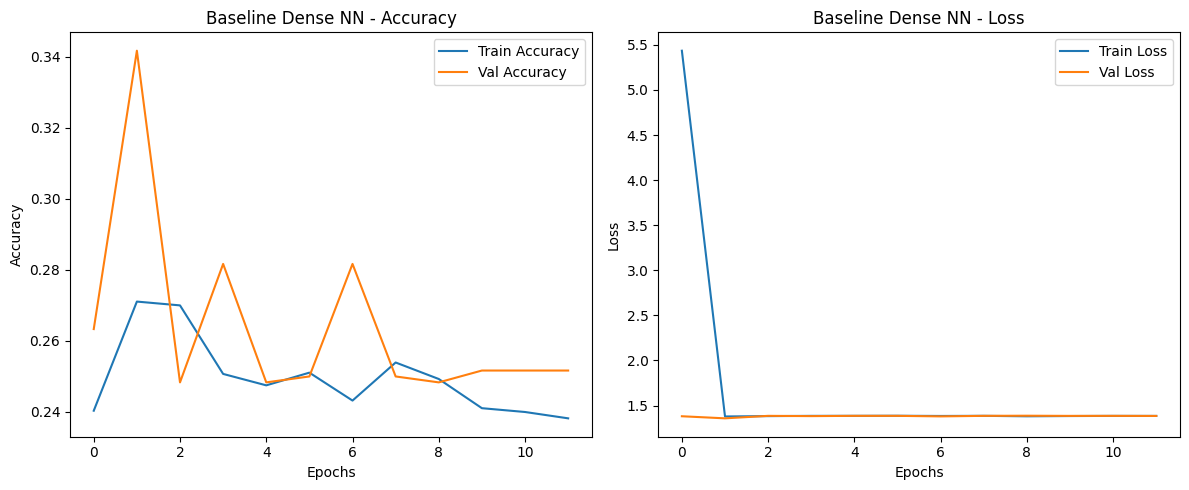

In [18]:
# Plot training history
def plot_training_history(history, title):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
plot_training_history(history_baseline, "Baseline Dense NN")


In [19]:
# Evaluate on test set
test_loss, test_acc = baseline_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Baseline Model Test Accuracy: {test_acc:.4f}")
y_pred = baseline_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=CLASSES))

Baseline Model Test Accuracy: 0.3183
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Classification Report:
              precision    recall  f1-score   support

     Buffalo       0.00      0.00      0.00       150
    Elephant       0.31      0.67      0.42       150
       Rhino       0.34      0.55      0.42       150
       Zebra       0.26      0.06      0.10       150

    accuracy                           0.32       600
   macro avg       0.23      0.32      0.23       600
weighted avg       0.23      0.32      0.23       600



C:\Users\mayer\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\mayer\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\mayer\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

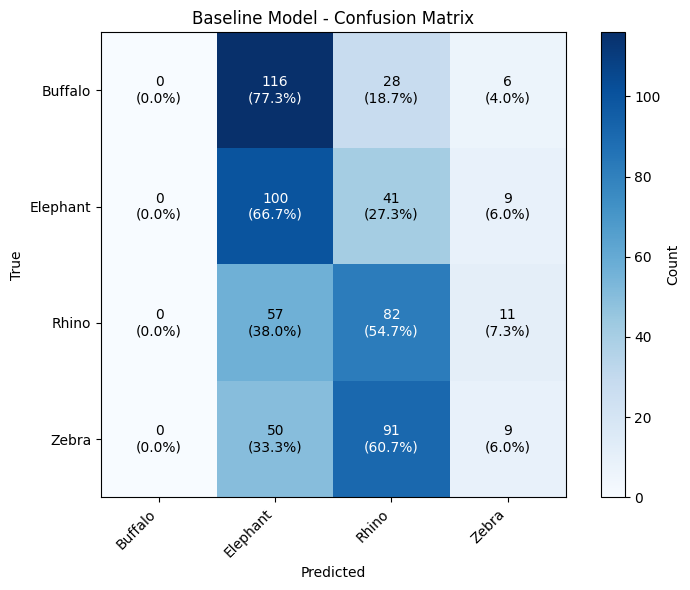

In [20]:
def plot_confusion_matrix(y_true, y_pred, classes, title, cmap='Blues'):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    im = plt.imshow(cm, cmap=cmap, vmin=0, interpolation='nearest')
    plt.colorbar(im, label='Count')

    plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
    plt.yticks(range(len(classes)), classes)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title + " - Confusion Matrix")
    

    threshold = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)",
                ha='center', va='center',
                color='white' if cm[i, j] > threshold else 'black'
            )

    plt.grid(False) 
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred_classes, CLASSES, title='Baseline Model')

### Baseline Limitations

Observed issues:

1. High parameter count: Flattening the images produces a very high-dimensional input, leading to millions of parameters in the first dense layer.
2. Loss of spatial structure: The flattening operation removes spatial relationships between pixels, preventing the model from learning local visual patterns.
3. No translation invariance: Similar patterns appearing at different image locations must be learned separately, reducing learning efficiency.
4. Chance-level performance: Training, validation, and test accuracy remain around 25–32%, which is close to random guessing for a four-class problem.guessing in a four-class classification task.
5. Prediction bias toward a single class:
The model predominantly predicts one class (Elephant), resulting in near-zero recall for the remaining classes.
6. Ineffective use of additional data:
Despite a larger dataset, the dense baseline fails to improve performance, indicating that dataset size alone is insufficient without appropriate inductive bias.

## 3. Convolutional Architecture Design

### Architectural Decisions and Justifications

Instead of using a deep or overly complex network, we implement a compact and well-structured CNN that highlights the advantages of convolutional layers while controlling the number of parameters.

### Architecture Decisions:

1. Number of Convolutional Layers: 3 blocks

   * Rationale: Enables hierarchical feature learning, from low-level edges and colors to higher-level textures and shapes.
   * Each block: Conv2D → BatchNormalization → ReLU → MaxPooling.

2. Kernel Size: 3×3

   * Rationale: Captures local spatial patterns efficiently while keeping the number of parameters low.
   * Using `padding='same'` preserves spatial resolution within each block.

3. Filter Progression: 32 → 64 → 128

   * Rationale: Gradual increase in the number of filters allows the network to learn increasingly complex visual features.
   * Early layers focus on edges and colors, while deeper layers capture textures and object parts.

4. Pooling Strategy: MaxPooling 2×2

   * Rationale: Reduces spatial dimensions by a factor of two after each block, lowering computational cost and providing limited translation invariance.

5. Activation Function: ReLU

   * Rationale: Introduces non-linearity and ensures efficient gradient propagation during training.

6. Feature Aggregation: Global Average Pooling

   * Rationale: Replaces Flatten to significantly reduce the number of parameters and prevent overfitting.
   * Encourages the model to learn spatially robust feature maps instead of relying on exact pixel positions.

7. Regularization: BatchNormalization and Dropout

   * Rationale:

     * BatchNormalization stabilizes and accelerates training.
     * Dropout (0.5 after pooling, 0.3 in the dense layer) reduces overfitting, which is especially important given the dataset size.

8. Dense Layers: Single hidden layer (128 units)

   * Rationale: Keeps the classifier simple and lightweight, allowing the convolutional layers to perform most of the feature extraction.

In [ ]:
CNN_EPOCHS = 30
# Data augmentation for training 
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom((-0.05, 0.05)),
    layers.RandomTranslation(0.05, 0.05),
], name="data_augmentation")

def create_cnn_model(input_shape, num_classes, filters=[32, 64, 128]):
    model = models.Sequential(name='Custom_CNN')

    # Block 1: Edge and color detection → output: 64×64×32
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(filters[0], (3, 3), padding='same', name='conv1'))
    model.add(layers.BatchNormalization(name='bn1'))
    model.add(layers.Activation('relu', name='relu1'))
    model.add(layers.MaxPooling2D((2, 2), name='pool1'))

    # Block 2: Texture and pattern detection → output: 32×32×64
    model.add(layers.Conv2D(filters[1], (3, 3), padding='same', name='conv2'))
    model.add(layers.BatchNormalization(name='bn2'))
    model.add(layers.Activation('relu', name='relu2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool2'))

    # Block 3: Part and shape detection → output: 16×16×128
    model.add(layers.Conv2D(filters[2], (3, 3), padding='same', name='conv3'))
    model.add(layers.BatchNormalization(name='bn3'))
    model.add(layers.Activation('relu', name='relu3'))
    model.add(layers.MaxPooling2D((2, 2), name='pool3'))

    # Classifier
    model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))
    model.add(layers.Dropout(0.5, name='dropout'))
    model.add(layers.Dense(128, activation='relu', name='dense1'))
    model.add(layers.Dropout(0.3, name='dropout2'))
    model.add(layers.Dense(num_classes, activation='softmax', name='output'))

    return model

cnn_model = create_cnn_model(INPUT_SHAPE, NUM_CLASSES)

cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

cnn_model.summary()

print(f"total parameters: {cnn_model.count_params():,}")
print(f"baseline parameters: {baseline_model.count_params():,}")
print(f"parameter reduction: {(baseline_model.count_params() - cnn_model.count_params()) / baseline_model.count_params() * 100:.1f}%")

Model: "Custom_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,172 (434.27 KB)

 Trainable params: 110,724 (432.52 KB)

 Non-trainable params: 448 (1.75 KB)

total parameters: 111,172
baseline parameters: 12,616,580
parameter reduction: 99.1%


### Data Augmentation

Given the small dataset size, we apply data augmentation to improve generalization:

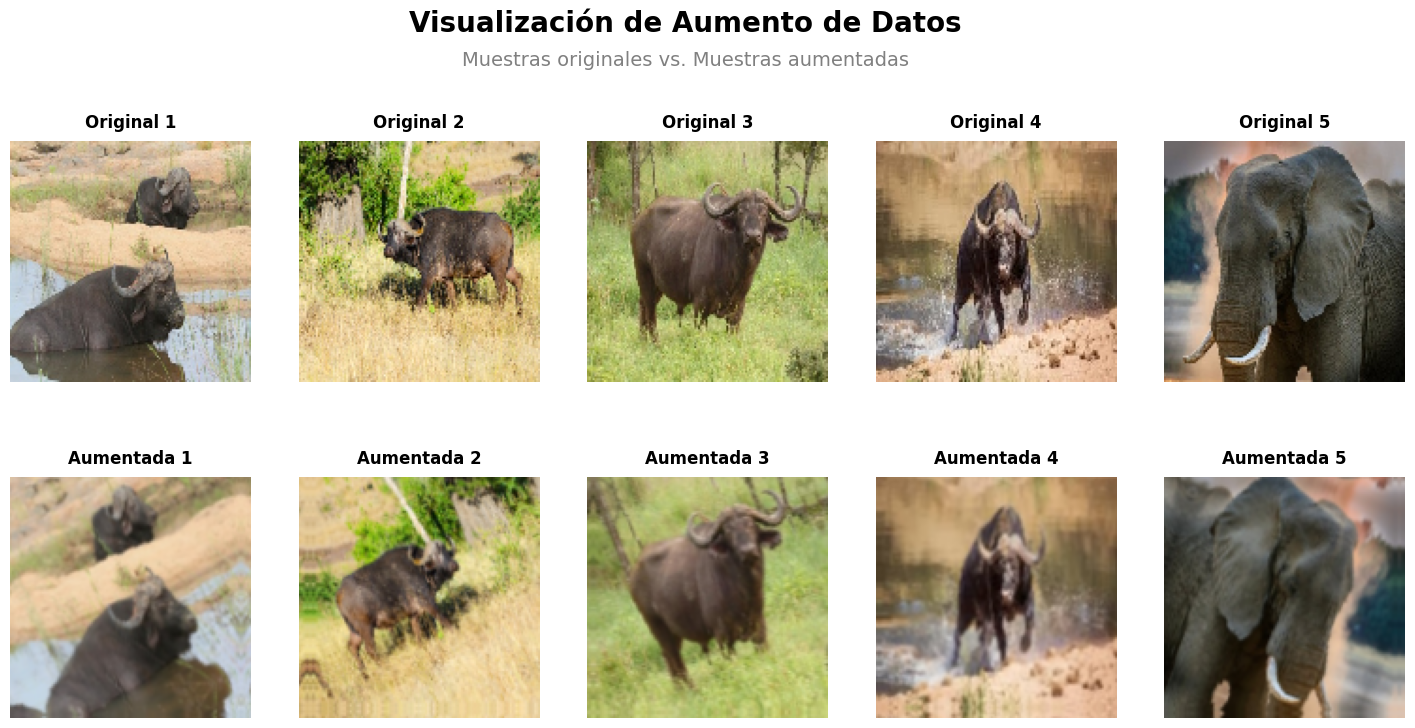

In [22]:
# Visualize augmented samples
def display_augmented_samples(data_augmentation, X_sample, num_samples=5):
    fig = plt.figure(figsize=(18, 8))
    fig.suptitle('Visualización de Aumento de Datos', 
                 fontsize=20, fontweight='bold', y=1.02)
    plt.figtext(0.5, 0.95, 
                'Muestras originales vs. Muestras aumentadas', 
                ha='center', fontsize=14, color='gray')
    
    for i in range(num_samples):
        original_image = X_sample[i]
        augmented_image = data_augmentation(
            tf.expand_dims(X_sample[i], axis=0), 
            training=True
        )[0].numpy()
        if original_image.dtype != np.uint8:
            original_image = np.clip(original_image, 0, 1)
            if original_image.max() <= 1.0:
                original_image = (original_image * 255).astype(np.uint8)
        
        if augmented_image.max() <= 1.0:
            augmented_image = np.clip(augmented_image, 0, 1)
            augmented_image_display = (augmented_image * 255).astype(np.uint8)
        else:
            augmented_image_display = np.clip(augmented_image, 0, 255).astype(np.uint8)
        
        ax1 = plt.subplot(2, num_samples, i + 1)
        ax1.imshow(original_image)
        ax1.set_title(f'Original {i+1}', fontsize=12, fontweight='bold', pad=10)
        ax1.axis('off')

        ax2 = plt.subplot(2, num_samples, i + num_samples + 1)
        ax2.imshow(augmented_image_display)
        ax2.set_title(f'Aumentada {i+1}', fontsize=12, fontweight='bold', pad=10)
        ax2.axis('off')
    plt.show()

display_augmented_samples(data_augmentation, X_train, num_samples=5)

In [23]:
# Train CNN with data augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
train_dataset = (
    train_dataset
    .shuffle(buffer_size=len(X_train), seed=SEED)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Validation dataset (no augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_cat))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

cnn_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True, 
        verbose=1,
        min_delta=1e-4
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-6,
        verbose=1
    ),
]
history_cnn = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=CNN_EPOCHS,
    class_weight=class_weight_dict,
    callbacks=cnn_callbacks,
    verbose=1
)

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 781ms/step - accuracy: 0.3700 - loss: 1.4157 - val_accuracy: 0.2500 - val_loss: 1.4139 - learning_rate: 3.0000e-04
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 60s 678ms/step - accuracy: 0.4207 - loss: 1.2660 - val_accuracy: 0.2500 - val_loss: 1.4360 - learning_rate: 3.0000e-04
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 58s 655ms/step - accuracy: 0.4596 - loss: 1.2202 - val_accuracy: 0.2517 - val_loss: 1.4769 - learning_rate: 3.0000e-04
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 60s 682ms/step - accuracy: 0.4732 - loss: 1.1940 - val_accuracy: 0.3000 - val_loss: 1.4113 - learning_rate: 3.0000e-04
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 61s 696ms/step - accuracy: 0.5004 - loss: 1.1631 - val_accuracy: 0.3667 - val_loss: 1.2761 - learning_rate: 3.0000e-04
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 60s 678ms/step - accuracy: 0.4957 - loss: 1.1563 - val_accuracy: 0.4833 - val_loss: 1.1588 - learning_rate: 3.0000e-04
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 62s 704ms/step - acc

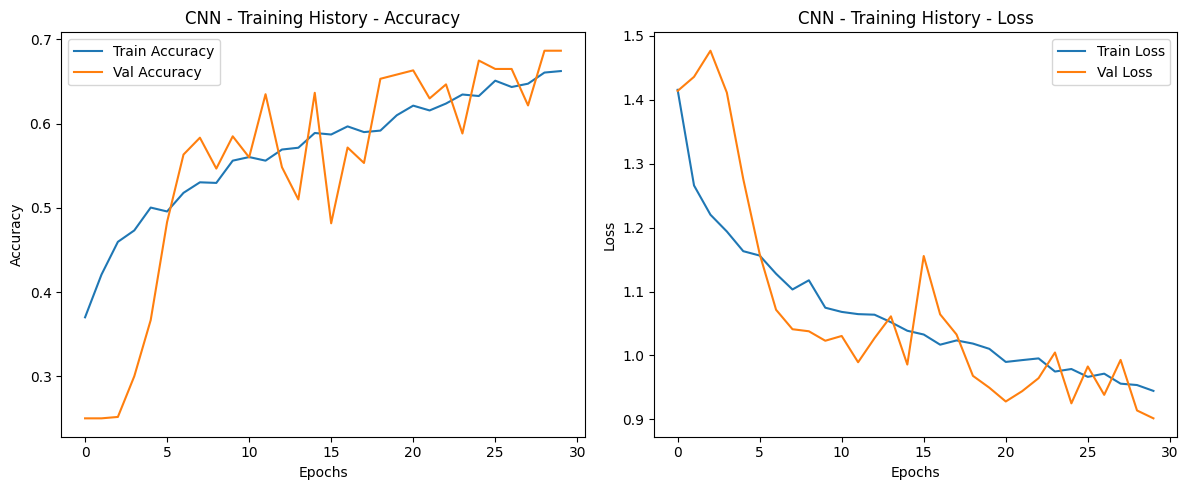

In [24]:
plot_training_history(history_cnn, "CNN - Training History")

In [25]:
# Evaluate on test set

test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"CNN Model Test Accuracy: {test_acc_cnn:.4f}")
y_pred_cnn = cnn_model.predict(X_test)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cnn_classes, target_names=CLASSES))

CNN Model Test Accuracy: 0.6783
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step

Classification Report:
              precision    recall  f1-score   support

     Buffalo       0.74      0.70      0.72       150
    Elephant       0.49      0.74      0.59       150
       Rhino       0.59      0.39      0.47       150
       Zebra       0.99      0.89      0.93       150

    accuracy                           0.68       600
   macro avg       0.70      0.68      0.68       600
weighted avg       0.70      0.68      0.68       600



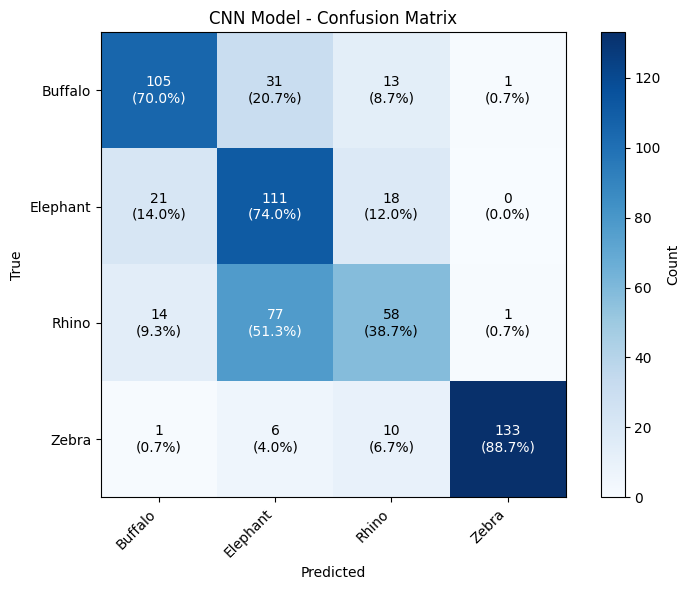

In [26]:

plot_confusion_matrix(y_test, y_pred_cnn_classes, CLASSES, title='CNN Model')

## 4. Controlled Experiments on the Convolutional Layer

In [ ]:
# Kernel Size Comparison
def create_cnn_with_kernel(input_shape, num_classes, kernel_size, filters=[32, 64, 128]):
    model = models.Sequential(name=f'CNN_Kernel_{kernel_size}x{kernel_size}')

    # Block 1
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(filters[0], (kernel_size, kernel_size), padding='same', name='conv1'))
    model.add(layers.BatchNormalization(name='bn1'))
    model.add(layers.Activation('relu', name='relu1'))
    model.add(layers.MaxPooling2D((2, 2), name='pool1'))

    # Block 2
    model.add(layers.Conv2D(filters[1], (kernel_size, kernel_size), padding='same', name='conv2'))
    model.add(layers.BatchNormalization(name='bn2'))
    model.add(layers.Activation('relu', name='relu2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool2'))

    # Block 3
    model.add(layers.Conv2D(filters[2], (kernel_size, kernel_size), padding='same', name='conv3'))
    model.add(layers.BatchNormalization(name='bn3'))
    model.add(layers.Activation('relu', name='relu3'))
    model.add(layers.MaxPooling2D((2, 2), name='pool3'))

    # Classifier
    model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))
    model.add(layers.Dropout(0.5, name='dropout'))
    model.add(layers.Dense(128, activation='relu', name='dense1'))
    model.add(layers.Dropout(0.3, name='dropout2'))
    model.add(layers.Dense(num_classes, activation='softmax', name='output'))

    return model

KERNEL_SIZES = [3, 5, 7]
EXPERIMENT_EPOCHS = 10
experiment_results = {}

print("CONTROLLED EXPERIMENT: KERNEL SIZE")

for ks in KERNEL_SIZES:
    print(f"Testing Kernel Size: {ks}×{ks}")
    
    model = create_cnn_with_kernel(INPUT_SHAPE, NUM_CLASSES, kernel_size=ks)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    param_count = model.count_params()
    conv_params = sum(p.numpy().size for layer in model.layers 
                      if 'conv' in layer.name.lower() for p in layer.trainable_weights)
    
    print(f"Total parameters: {param_count:,}")
    print(f"Conv layer parameters: {conv_params:,} ({conv_params/param_count*100:.1f}%)")
    print(f"Weights per kernel: {ks * ks}")
    
    exp_callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
        ),
    ]
    
    import time
    start_time = time.time()
    
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EXPERIMENT_EPOCHS,
        class_weight=class_weight_dict,
        callbacks=exp_callbacks,
        verbose=2  # Less verbose for cleaner output
    )
    
    train_time = time.time() - start_time
    
    val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)
    y_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)
    
    experiment_results[ks] = {
        'model': model,
        'history': history,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'params': param_count,
        'conv_params': conv_params,
        'y_pred': y_pred,
        'epochs_trained': len(history.history['loss']),
        'train_time': train_time,
    }
    
    print(f"\nResults:")
    print(f"   Val Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"   Val Loss:     {val_loss:.4f}")
    print(f"   Epochs:       {len(history.history['loss'])}")
    print(f"   Train time:   {train_time/60:.1f} minutes")
    


CONTROLLED EXPERIMENT: KERNEL SIZE

Testing Kernel Size: 3×3
Total parameters: 111,172
Conv layer parameters: 93,248 (83.9%)
Weights per kernel: 9
Epoch 1/10
88/88 - 72s - 817ms/step - accuracy: 0.3814 - loss: 1.3227 - val_accuracy: 0.2717 - val_loss: 1.4327 - learning_rate: 0.0010
Epoch 2/10
88/88 - 59s - 671ms/step - accuracy: 0.4729 - loss: 1.1226 - val_accuracy: 0.2500 - val_loss: 1.4524 - learning_rate: 0.0010
Epoch 3/10
88/88 - 55s - 627ms/step - accuracy: 0.5136 - loss: 1.0507 - val_accuracy: 0.2267 - val_loss: 1.5787 - learning_rate: 0.0010
Epoch 4/10
88/88 - 55s - 622ms/step - accuracy: 0.5475 - loss: 0.9795 - val_accuracy: 0.2783 - val_loss: 1.4927 - learning_rate: 0.0010
Epoch 5/10
88/88 - 55s - 631ms/step - accuracy: 0.5457 - loss: 0.9640 - val_accuracy: 0.3900 - val_loss: 1.2979 - learning_rate: 0.0010
Epoch 6/10
88/88 - 59s - 674ms/step - accuracy: 0.5689 - loss: 0.9515 - val_accuracy: 0.5233 - val_loss: 0.9530 - learning_rate: 0.0010
Epoch 7/10
88/88 - 61s - 691ms/step 

In [44]:
print("KERNEL SIZE EXPERIMENT — RESULTS SUMMARY")

print(f"{'Kernel':>8} {'Val Acc':>10} {'Val Loss':>10} {'Total Params':>14} "
      f"{'Conv Params':>13} {'Epochs':>8} {'Time (min)':>11}")

for ks in KERNEL_SIZES:
    r = experiment_results[ks]
    print(f"{ks}×{ks:>5} {r['val_acc']:>10.4f} {r['val_loss']:>10.4f} "
          f"{r['params']:>14,} {r['conv_params']:>13,} "
          f"{r['epochs_trained']:>8} {r['train_time']/60:>10.1f}")


# Find best model
best_ks = max(experiment_results, key=lambda k: experiment_results[k]['val_acc'])
print(f"Best performing kernel size: {best_ks}×{best_ks} "
      f"(Val Acc: {experiment_results[best_ks]['val_acc']:.2%})")


KERNEL SIZE EXPERIMENT — RESULTS SUMMARY
  Kernel    Val Acc   Val Loss   Total Params   Conv Params   Epochs  Time (min)
3×    3     0.6117     0.8444        111,172        93,248       10        9.9
5×    5     0.6133     0.8817        276,548       258,624       10       13.0
7×    7     0.5583     0.9537        524,612       506,688       10       19.9
Best performing kernel size: 5×5 (Val Acc: 61.33%)


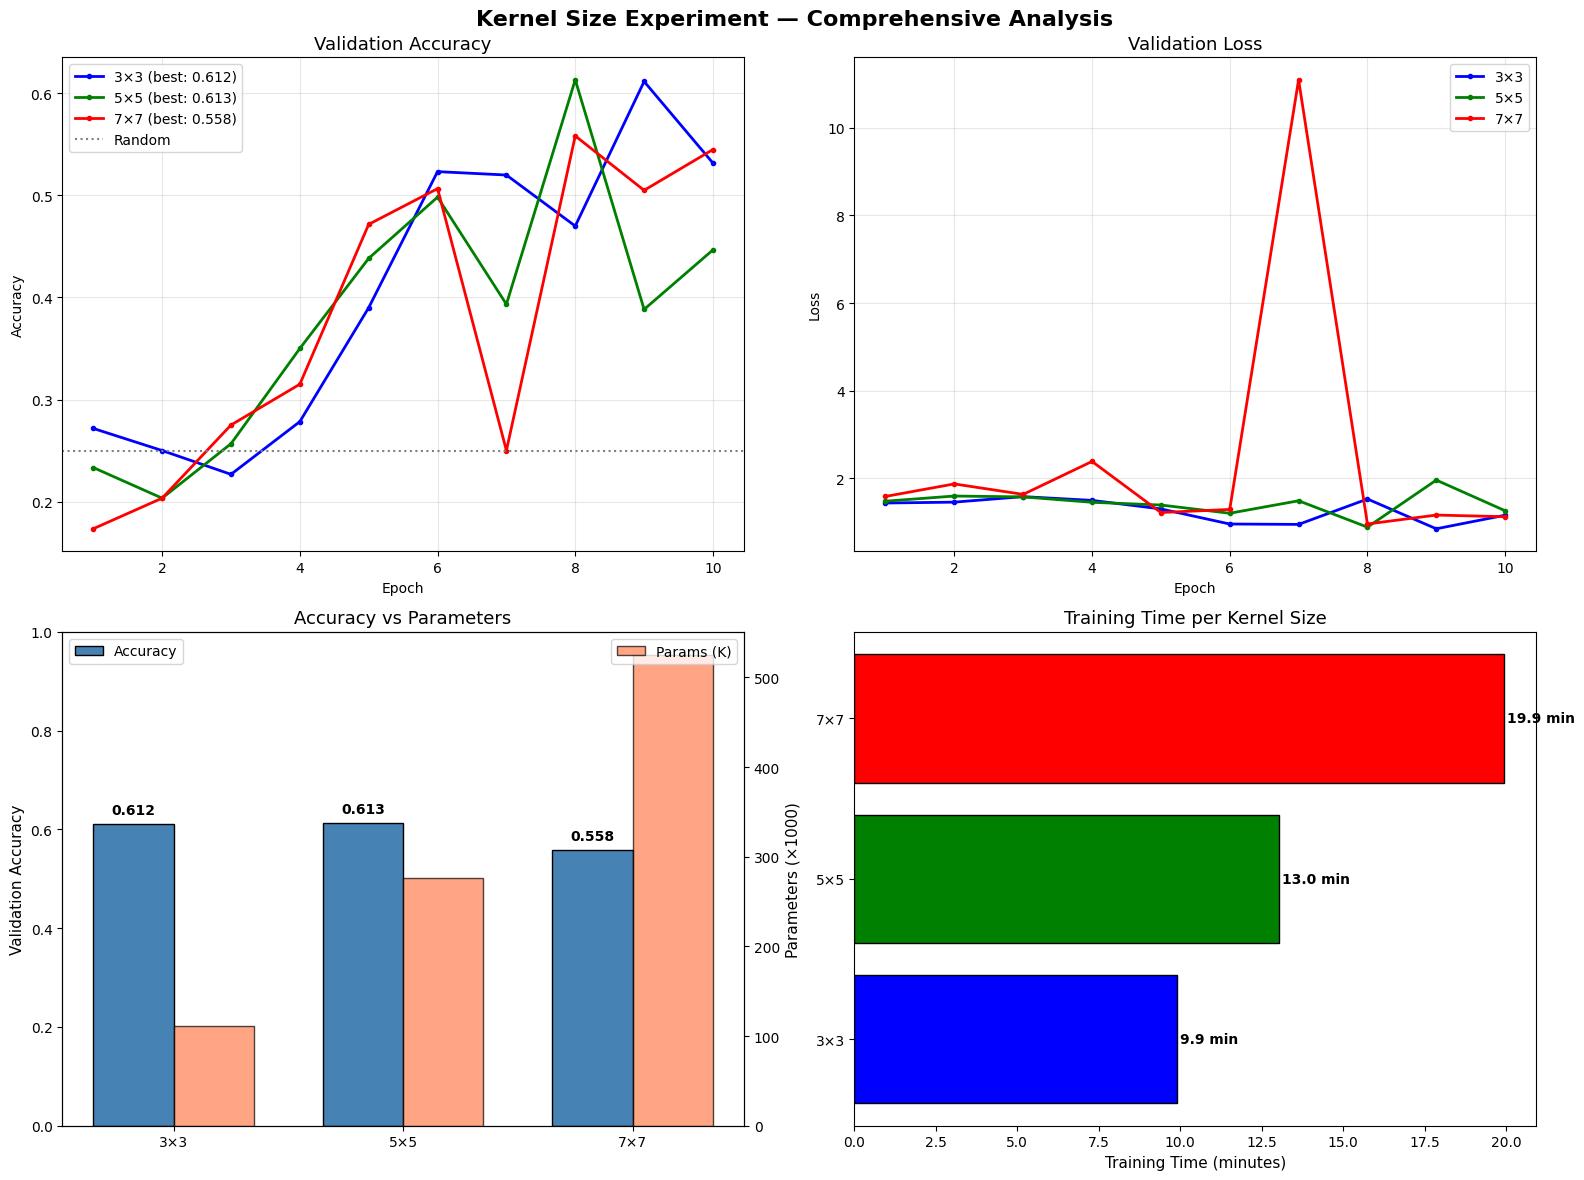

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Kernel Size Experiment — Comprehensive Analysis', 
             fontsize=16, fontweight='bold')

colors_dict = {3: 'blue', 5: 'green', 7: 'red'}

# 1. Validation Accuracy over epochs
ax = axes[0, 0]
for ks in KERNEL_SIZES:
    h = experiment_results[ks]['history']
    epochs = range(1, len(h.history['val_accuracy']) + 1)
    ax.plot(epochs, h.history['val_accuracy'], '-o', markersize=3, 
            color=colors_dict[ks], linewidth=2,
            label=f'{ks}×{ks} (best: {experiment_results[ks]["val_acc"]:.3f})')
ax.axhline(y=1/NUM_CLASSES, color='gray', linestyle=':', label='Random')
ax.set_title('Validation Accuracy', fontsize=13)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Validation Loss over epochs
ax = axes[0, 1]
for ks in KERNEL_SIZES:
    h = experiment_results[ks]['history']
    epochs = range(1, len(h.history['val_loss']) + 1)
    ax.plot(epochs, h.history['val_loss'], '-o', markersize=3, 
            color=colors_dict[ks], linewidth=2, label=f'{ks}×{ks}')
ax.set_title('Validation Loss', fontsize=13)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Bar chart: Accuracy vs Parameters
ax = axes[1, 0]
ks_labels = [f'{ks}×{ks}' for ks in KERNEL_SIZES]
accs = [experiment_results[ks]['val_acc'] for ks in KERNEL_SIZES]
params = [experiment_results[ks]['params'] for ks in KERNEL_SIZES]

x = np.arange(len(KERNEL_SIZES))
width = 0.35

bars1 = ax.bar(x - width/2, accs, width, label='Accuracy', 
               color='steelblue', edgecolor='black')
ax_twin = ax.twinx()
bars2 = ax_twin.bar(x + width/2, [p/1000 for p in params], width, 
                     label='Params (K)', color='coral', alpha=0.7, edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(ks_labels)
ax.set_ylabel('Validation Accuracy', fontsize=11)
ax_twin.set_ylabel('Parameters (×1000)', fontsize=11)
ax.set_title('Accuracy vs Parameters', fontsize=13)
ax.set_ylim([0, 1.0])
ax.legend(loc='upper left')
ax_twin.legend(loc='upper right')

# Add value labels
for bar, acc in zip(bars1, accs):
    ax.text(bar.get_x() + bar.get_width() / 2., acc + 0.02,
            f'{acc:.3f}', ha='center', fontweight='bold', fontsize=10)

# 4. Training time comparison
ax = axes[1, 1]
times = [experiment_results[ks]['train_time'] / 60 for ks in KERNEL_SIZES]
bars = ax.barh(ks_labels, times, color=[colors_dict[ks] for ks in KERNEL_SIZES], 
               edgecolor='black')
ax.set_xlabel('Training Time (minutes)', fontsize=11)
ax.set_title('Training Time per Kernel Size', fontsize=13)
for bar, t in zip(bars, times):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2.,
            f'{t:.1f} min', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

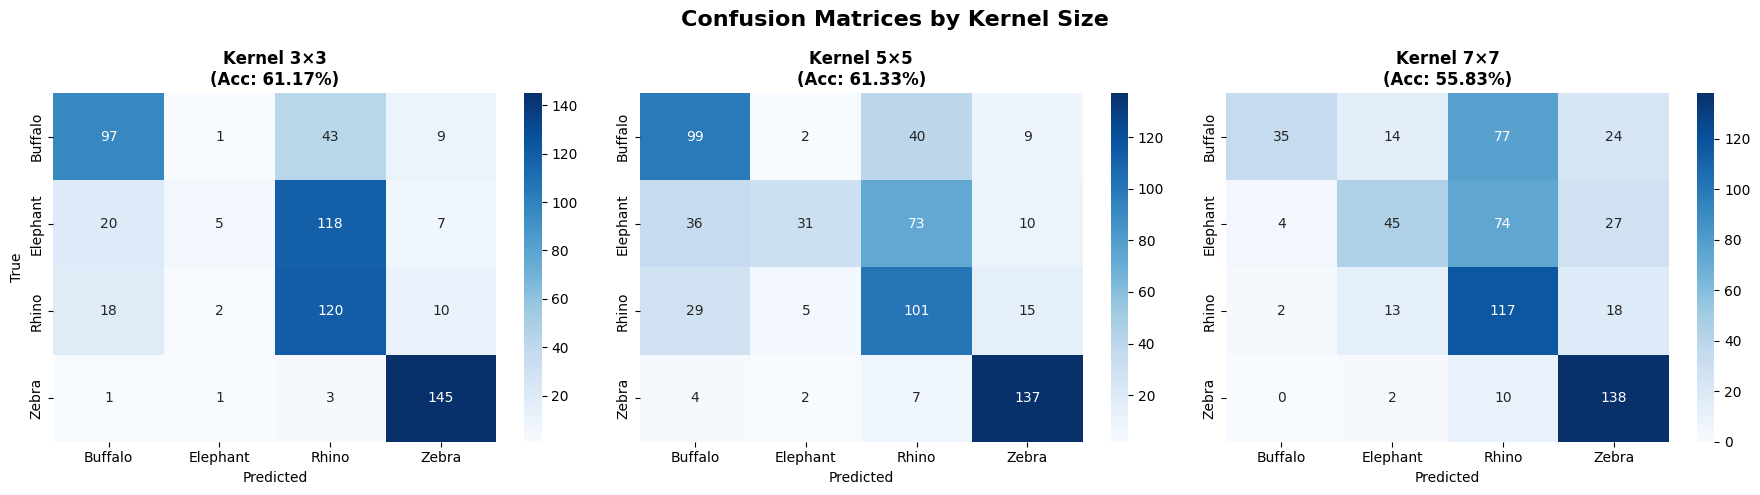

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices by Kernel Size', fontsize=16, fontweight='bold')

for idx, ks in enumerate(KERNEL_SIZES):
    cm = confusion_matrix(y_val, experiment_results[ks]['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=CLASSES, yticklabels=CLASSES)
    axes[idx].set_title(f'Kernel {ks}×{ks}\n(Acc: {experiment_results[ks]["val_acc"]:.2%})', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    if idx == 0:
        axes[idx].set_ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
# All Models — Side-by-Side
print("FINAL MODEL COMPARISON")
print(f"{'Model':<30} {'Val Acc':>10} {'Val Loss':>10} {'Parameters':>14} {'Acc/Param':>12}")
baseline_val_loss, baseline_val_acc = baseline_model.evaluate(X_val, y_val_cat, verbose=0)

cnn_val_loss, cnn_val_acc = cnn_model.evaluate(X_val, y_val_cat, verbose=0)
# Baseline
acc_per_param_baseline = baseline_val_acc / baseline_model.count_params() * 1e6
print(f"{'Baseline (Dense)':<30} {baseline_val_acc:>10.4f} {baseline_val_loss:>10.4f} "
      f"{baseline_model.count_params():>14,} {acc_per_param_baseline:>11.2f}")

# CNN
acc_per_param_cnn = cnn_val_acc / cnn_model.count_params() * 1e6
print(f"{'CNN (3×3 kernel)':<30} {cnn_val_acc:>10.4f} {cnn_val_loss:>10.4f} "
      f"{cnn_model.count_params():>14,} {acc_per_param_cnn:>11.2f}")

# Experiments
for ks in KERNEL_SIZES:
    r = experiment_results[ks]
    acc_per_param = r['val_acc'] / r['params'] * 1e6
    name = f"CNN ({ks}×{ks} kernel)"
    print(f"{name:<30} {r['val_acc']:>10.4f} {r['val_loss']:>10.4f} "
          f"{r['params']:>14,} {acc_per_param:>11.2f}")

FINAL MODEL COMPARISON
Model                             Val Acc   Val Loss     Parameters    Acc/Param
Baseline (Dense)                   0.3417     1.3586     12,616,580        0.03
CNN (3×3 kernel)                   0.6867     0.9016        111,172        6.18
CNN (3×3 kernel)                   0.6117     0.8444        111,172        5.50
CNN (5×5 kernel)                   0.6133     0.8817        276,548        2.22
CNN (7×7 kernel)                   0.5583     0.9537        524,612        1.06


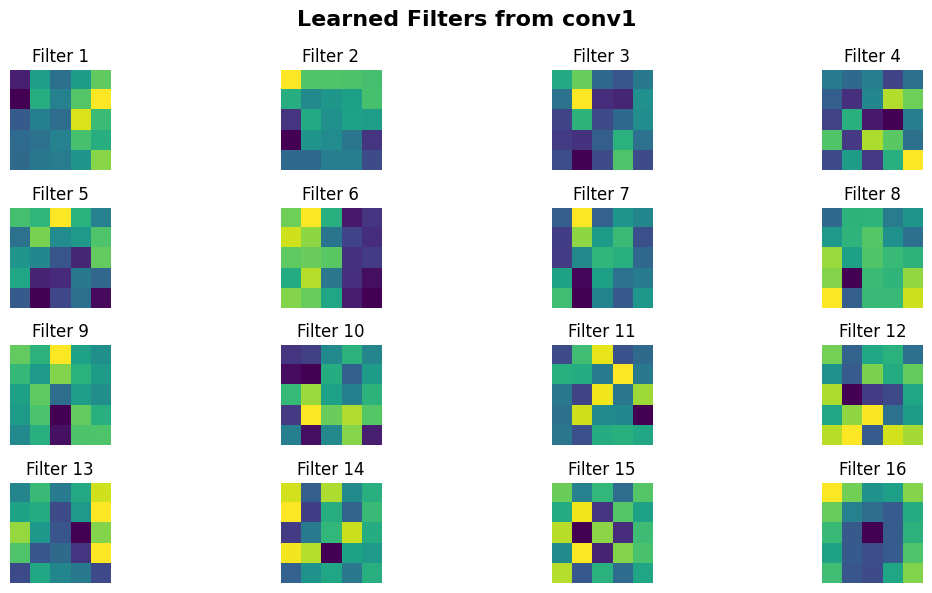

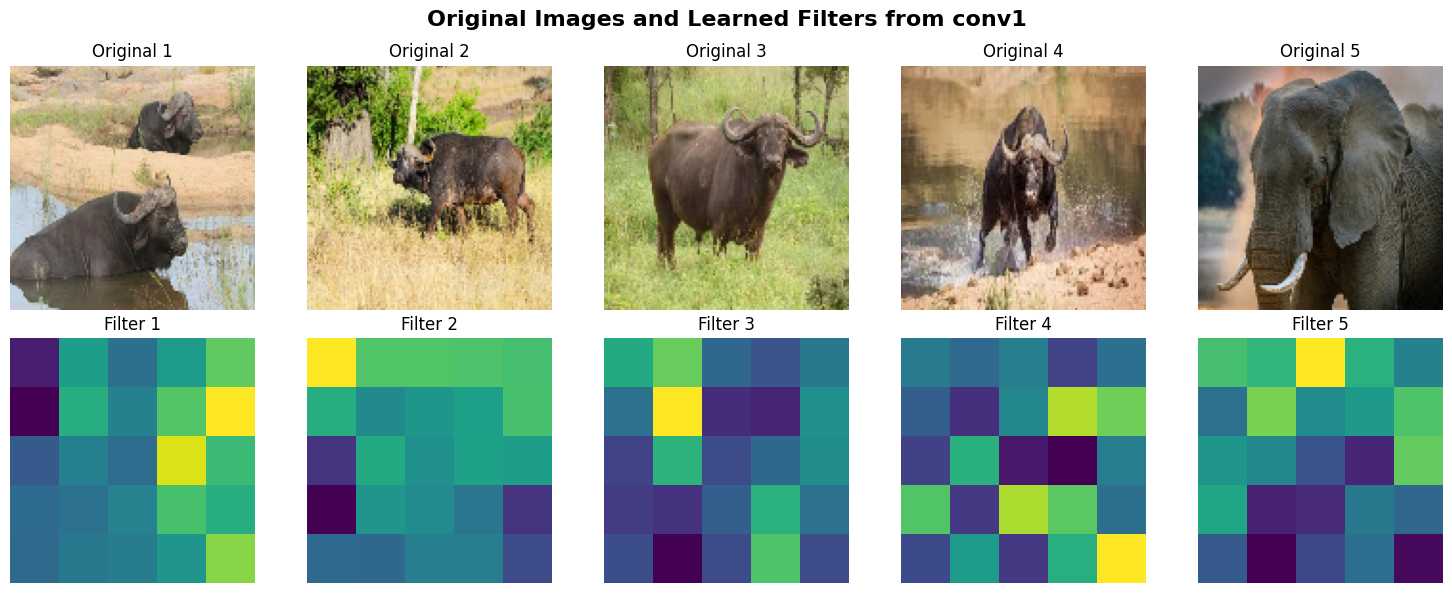

In [43]:
# Visualize Learned Filters (First Conv Layer)
def visualize_filters(model, layer_name, num_filters=16):
    layer = model.get_layer(name=layer_name)
    filters, biases = layer.get_weights()
    filters_min, filters_max = filters.min(), filters.max()
    filters = (filters - filters_min) / (filters_max - filters_min)
    
    n_filters = min(num_filters, filters.shape[-1])
    plt.figure(figsize=(12, 6))
    for i in range(n_filters):
        f = filters[:, :, :, i]
        f_mean = f.mean(axis=-1)
        plt.subplot(4, 4, i + 1)
        plt.imshow(f_mean, cmap='viridis')
        plt.axis('off')
        plt.title(f'Filter {i+1}')
    plt.suptitle(f'Learned Filters from {layer_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_filters(experiment_results[best_ks]['model'], layer_name='conv1', num_filters=16)

#show original
def display_original_and_learned_filters(model, layer_name, X_sample, num_samples=5):
    layer = model.get_layer(name=layer_name)
    filters, biases = layer.get_weights()
    filters_min, filters_max = filters.min(), filters.max()
    filters = (filters - filters_min) / (filters_max - filters_min)
    
    n_filters = min(num_samples, filters.shape[-1])
    plt.figure(figsize=(15, 6))
    
    for i in range(n_filters):
        # Original image
        plt.subplot(2, n_filters, i + 1)
        plt.imshow(X_sample[i])
        plt.axis('off')
        plt.title(f'Original {i+1}')
        
        # Learned filter
        f = filters[:, :, :, i]
        f_mean = f.mean(axis=-1)
        plt.subplot(2, n_filters, i + n_filters + 1)
        plt.imshow(f_mean, cmap='viridis')
        plt.axis('off')
        plt.title(f'Filter {i+1}')
    
    plt.suptitle(f'Original Images and Learned Filters from {layer_name}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
display_original_and_learned_filters(experiment_results[best_ks]['model'], 
                                 layer_name='conv1', X_sample=X_train, num_samples=5)

## 5. Interpretation and Architectural Reasoning

### Why did convolutional layers outperform the baseline?

The convolutional models dramatically outperformed the baseline dense network because they are architecturally aligned with the structure of image data.  
The baseline model flattened the 128×128×3 images into a 49,152-dimensional vector, destroying all spatial relationships between pixels. As a result, it had to learn visual patterns (edges, textures, shapes) from scratch using fully connected layers, which led to:

- An explosion in parameters (~12.6M parameters)
- Poor generalization and severe class confusion
- Test accuracy close to random guessing (~32%)

In contrast, CNNs achieved ~68% accuracy with ~100× fewer parameters because:

- Convolutions preserve spatial locality and hierarchical structure
- Early layers learned edges and color gradients, deeper layers learned textures and animal-specific patterns
- Weight sharing drastically reduced the number of parameters
- Pooling and global average pooling added robustness to small translations and background noise

This efficiency is reflected in the *accuracy-per-parameter* metric: CNNs were orders of magnitude more effective than the dense baseline.

### What inductive bias does convolution introduce?

Convolution introduces several strong and beneficial inductive biases for vision tasks:

1. Locality  
   Filters assume that meaningful features are local (e.g., edges, spots, stripes).

2. Translation Equivariance  
   The same feature detector is applied across the entire image, meaning a zebra stripe can be recognized anywhere.

3. Parameter Sharing  
   The same kernel weights are reused spatially, enforcing consistency and reducing overfitting.

4. Hierarchical Feature Learning  
   Stacked convolutions naturally learn:
   - Low-level features (edges, corners)
   - Mid-level features (textures, patterns)
   - High-level features (animal body parts, shapes)

The kernel-size experiment reinforces this bias:
- Small kernels (3×3, 5×5) performed best because they focus on local patterns
- Large kernels (7×7) increased parameters, training time, and overfitting risk without improving accuracy

### In what type of problems would convolution *not* be appropriate?

Convolution is not ideal when its assumptions do not match the data structure, for example:

1. Tabular Data  
   Features have no spatial or local ordering (e.g., credit scoring, medical records).

2. Purely Symbolic or Categorical Data  
   IDs, categories, or logical rules without spatial meaning.

3. Global Dependency Problems  
   Tasks where every input dimension depends equally on all others (e.g., some graph problems, certain optimization tasks).

4. Small Non-Structured Inputs  
   When inputs are already low-dimensional vectors, dense layers are simpler and more effective.

In short, convolution excels when local patterns repeat across space. When that assumption breaks, its inductive bias becomes a limitation rather than an advantage.

Conclusion:  
The experiment clearly shows that CNNs are not just “bigger dense networks,” but architectures that embed prior knowledge about images. This inductive bias explains why they achieve far better performance, efficiency, and generalization in visual classification tasks.
